In [3]:
from __future__ import print_function, division
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import time
import random
%matplotlib inline


import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms



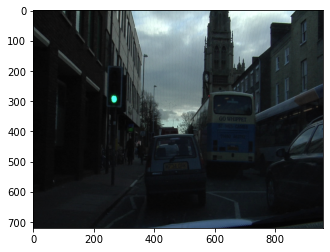

In [4]:
data_dir = 'C:\\Users\\91958\\camvid\\camvid\\'
image_dir = 'C:\\Users\\91958\\camvid\\camvid\\images\\'

img = Image.open(image_dir + '0001TP_006690.png')
plt.imshow(img); plt.show()

img_array = np.array(img)

In [5]:
img_array.shape

(720, 960, 3)

In [6]:

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
import os
from tqdm import tqdm
from numpy import asarray
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),       
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize((0.5,), (0.5,))
                                           ])


label_dir = "C:\\Users\\91958\\camvid\\camvid\\labels\\"

def get_data(image_dir, label_dir):
    
    x_train= []
    y_train =[]
    
    for idx, image in enumerate(os.listdir(image_dir)):
        image = Image.open(image_dir+ image)
        img = asarray(image)/ 255
        img = resize(img , (3, 224, 224))
        x_train.append(img)                 
       
        
    for idx ,label in enumerate(os.listdir(label_dir)):
        label = Image.open(label_dir+ label)
        label = asarray(label)/ 255
        label = resize(label , (1, 224, 224))
        y_train.append(label) 
        
#     x_train1 = [t.numpy() for t in x_train]
#     y_train1 = [t.numpy() for t in y_train]


    return np.array(x_train).reshape((3,701,224,224)), np.array(y_train).reshape((1,701,224,224))


In [13]:
dataset = get_data(image_dir, label_dir)

In [1]:
images, labels = dataset

NameError: name 'dataset' is not defined

In [2]:
labels.shape

NameError: name 'labels' is not defined

In [22]:
from torch.utils.data import Dataset, DataLoader ,random_split

trainloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

In [28]:
images, labels = trainloader

In [31]:
print(labels.shape)
print(images.shape)



torch.Size([1, 1, 701, 224, 224])
torch.Size([1, 3, 701, 224, 224])


In [23]:
import torch
import torch.nn as nn
from torchvision import models

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2)
        
    )
def convrelu1(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True)
        
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.convlayer1 = convrelu(3, 64, 3, 1)
        self.convlayer2 = convrelu(64, 128, 3, 1)
        self.convlayer3 = convrelu(128 , 256 , 3, 1)
        self.convlayer4 = convrelu(256, 512 ,3, 1)
        
        self.layer4_1x1 = convrelu1(512, 512, 1, 0)
        self.layer3_1x1 = convrelu1(256, 256, 1, 0)
        self.layer2_1x1 = convrelu1(128, 128, 1, 0)
        self.layer1_1x1 = convrelu1(64, 64, 1, 0)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu1(512+256, 512, 3, 1)
        self.conv_up2 = convrelu1(512+128, 256, 3, 1)
        self.conv_up1 = convrelu1(256+64 , 64, 3, 1)
        

        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    
    def forward(self , x):
        
        c1 = self.convlayer1(x)
        c2 = self.convlayer2(c1)
        c3 = self.convlayer3(c2)
        c4 = self.convlayer4(c3)
        
        c4 = self.layer4_1x1(c4)
        x = self.upsample(c4)
        c3 = self.layer3_1x1(c3)
        x = torch.cat([x, c3], dim=1) 
        x = self.conv_up3(x)
        
       
        x = self.upsample(x)
        c2 = self.layer2_1x1(c2)
        x = torch.cat([x, c2], dim=1)
        x = self.conv_up2(x)
        
        
        x = self.upsample(x)
        c1 = self.layer1_1x1(c1)
        x = torch.cat([x, c1], dim=1)
        x = self.conv_up1(x)
        
        x = self.upsample(x)
        
        out = self.conv_last(x)
        return out
               


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
model = UNet(n_class=5)
model = model.to(device)

In [26]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model.to(device).parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [32]:
from sklearn.metrics import precision_score,f1_score
num_epochs = 5
for epoch in range(num_epochs):
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0): 
        exp_lr_scheduler.step()
        
        for images, labels in trainloader:
                images = images.to(device) 
                labels = labels.to(device)
                
                optimizer_ft.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, torch.max(labels, 1)[1])
                loss.backward()
                optimizer_ft.step()
                

                total += labels.size(0)
                preds = torch.sigmoid(outputs).data > 0.5
                preds = preds.to(torch.float32)
                
                correct += f1_score(labels.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * images.size(0)
                
                print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs, loss.item(), correct/total))
        
#         torch.save(net.state_dict(), os.path.join(model_dir, 'epoch-{}.pt'.format(epoch)))

print('Finished Training')

ValueError: not enough values to unpack (expected 2, got 1)